<a href="https://colab.research.google.com/github/gyuchangShim/yolo_nas_practice/blob/main/custom_dataset_yolo_nas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install super-gradients==3.5.0
!pip install roboflow

In [ ]:
import cv2
import torch

from IPython.display import clear_output
# super-gradients에서 PPYoloELoss를 받아올 때 오류 발생(loss: ~ )
# 그래서 super-gradients --> paddleslim.nas.loss로 변경
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
use_cuda = torch.cuda.is_available()
if use_cuda:
  print(torch.cuda.get_device_name(0))

In [3]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='Detection_yolonas_practice', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="aIU6ug3LhFpJCcpMteMN")
project = rf.workspace("mjuaiimages").project("mju_ai_week02")
version = project.version(1)
dataset = version.download("yolov5")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

cuda 캐시 삭제

In [5]:
# dataset_setup
dataset_params = {
    'data_dir': '/content/mju_ai_week02-1',
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'valid/images',
    'val_labels_dir': 'valid/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': ['cat', 'dog']
}

In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
      'batch_size': 16,
      'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
      'batch_size': 16,
      'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
      'batch_size': 16,
      'num_workers': 2
    }
)

clear_output()

In [ ]:
train_data.dataset.transforms
train_data.dataset.dataset_params['transforms'][1]
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

In [ ]:
train_data.dataset.plot()

In [9]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights = "coco")

[2024-03-30 10:52:57] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 88.8MB/s]
[2024-03-30 10:52:58] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


- 모델 인스턴스화: yolo-nas의 3가지 모델(l, s, m) 모두 사용 가능
-> num_classes 인수 & pretrained_weights 추가 필요

In [ ]:
# metric_to_watch: mAP@0.50에서 error
# mAP@0.50 인식 불가 -> why?
train_params = {
    'silent_mode': True,
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # epoch 횟수는 수정 필요
    "max_epochs": 15,
    "mixed_precision": True,
    # 손실 함수 결정
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_matrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [7]:
train_params = { # 모델에 다양한 학습 변수가 포함된 Python dictionary
    "average_best_models": True, # True로 설정하면 학습중에 가장 좋은 모델의 평균을 사용하여 최종 모델을 생성
    "warmup_mode": "linear_epoch_step", # linear_epoch_step으로 설정하면 학습률을 선형적으로 증가시킨다.
    "warmup_initial_lr": 1e-6, # 합습률을 le-6 으로 설정, (0.000001)
    "lr_warmup_epochs": 3, # 학습률을 3에폭동안 증가.
    "initial_lr": 5e-4, # 학습률을 5e-4로 시작한다. (0.0005)
    "lr_mode": "cosine",# 학습률을 코사인 함수로 감소시킨다.
    "cosine_final_lr_ratio": 0.1, # 0.1로 설정하면 최종 학습률의 0.1로 감소시킨다.
    "optimizer": "AdamW",# 모델이 실제 결과와 예측 결과의 차이를 최소화 시키는 알고리즘(즉, 사용하려는 손실함수)을 AdamW로 사용
    "optimizer_params": {"weight_decay": 0.0001}, # 가중치 감소를 0.0001로 설정 (weight decay : 모델의 가중치가 너무 커지는 것을 방지하는 규제 기법)
    "zero_weight_decay_on_bias_and_bn": True, # True로 설정하면 바이어스 및 배치 정규화에 가중치 감소를 적용하지 않는다.
    "ema": True, # True로 설정하면 지수 이동 평균 (EMA)를 사용한다.
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},# EMA 감소율을 0.9로 설정하고 감소 유형을 "threshold"로 설정.
    "max_epochs": 10, # 10으로 설정하면 최대 에폭수를 10으로 설정한다.
    "mixed_precision": True, # True로 설정하면 혼합 정밀도를 사용

    "loss": PPYoloELoss(
        use_static_assigner=False, # 정적 할당자 또는 작업 할당 할당자 사용 여부
        num_classes=len(dataset_params['classes']), # 모델이 감지할 수 있는 클래스 수를 지정
        reg_max=16
    ),
    "valid_metrics_list": [ # DetectionMetrics_050를 사용하여 검증 지표 목록을 설정

        DetectionMetrics_050(
            score_thres=0.1, # 검출에 사용되는 최소 점수를 지정, 해당 변수를 높이면 더 정확한 검출을 얻을 수 있지만 검출되는 양이 더 적어질 수 있다.
            top_k_predictions=300, # 각 이미지에 대해 예측할 최대 개수를 지정
            num_cls=len(dataset_params['classes']), # 모델이 감지할 수 있는 클래스 수를 지정
            normalize_targets=True, # 타겟을 정규화할지 여부를 지정

            post_prediction_callback=PPYoloEPostPredictionCallback( # 검출을 조정하는데 사용되는 콜백 함수

                score_threshold=0.01, # 최종 검출에 사용되는 최소 점수를 지정.
                nms_top_k=1000, # Non-Maximum Suppression(NMS) 알고리즘에서 고려할 상위 k개 박스를 지정, (상위 1000개의 박스를 고려)
                max_predictions=300, # 최종 검출에 사용되는 최대 개수를 지정
                nms_threshold=0.7 #  NMS 알고리즘에서 사용할 IoU(Intersection over Union) 임계값을 지정

            )
        )
    ],

    "metric_to_watch": 'mAP@0.50'
}

In [10]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-03-30 10:53:01] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240330_105301_560529`
[2024-03-30 10:53:01] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Detection_yolonas_practice/RUN_20240330_105301_560529
[2024-03-30 10:53:01] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/Detection_yolonas_practice/RUN_20240330_105301_560529/console_Mar30_10_53_01.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
[2024-03-30 10:53:06] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            81         (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         5       

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.1223
│   ├── Ppyoloeloss/loss_iou = 0.6271
│   ├── Ppyoloeloss/loss_dfl = 0.7998
│   └── Ppyoloeloss/loss = 3.5491
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4009
    ├── Ppyoloeloss/loss_iou = 0.4949
    ├── Ppyoloeloss/loss_dfl = 0.7369
    ├── Ppyoloeloss/loss = 3.6327
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0472
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
[2024-03-30 10:53:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240330_105301_560529/ckpt_best.pth
[2024-03-30 10:53:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.13110975921154022


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9574
│   │   ├── Epoch N-1      = 2.1223 (↘ -0.1649)
│   │   └── Best until now = 2.1223 (↘ -0.1649)
│   ├── Ppyoloeloss/loss_iou = 0.6041
│   │   ├── Epoch N-1      = 0.6271 (↘ -0.0229)
│   │   └── Best until now = 0.6271 (↘ -0.0229)
│   ├── Ppyoloeloss/loss_dfl = 0.8078
│   │   ├── Epoch N-1      = 0.7998 (↗ 0.0081)
│   │   └── Best until now = 0.7998 (↗ 0.0081)
│   └── Ppyoloeloss/loss = 3.3693
│       ├── Epoch N-1      = 3.5491 (↘ -0.1797)
│       └── Best until now = 3.5491 (↘ -0.1797)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7401
    │   ├── Epoch N-1      = 2.4009 (↘ -0.6609)
    │   └── Best until now = 2.4009 (↘ -0.6609)
    ├── Ppyoloeloss/loss_iou = 0.5112
    │   ├── Epoch N-1      = 0.4949 (↗ 0.0163)
    │   └── Best until now = 0.4949 (↗ 0.0163)
    ├── Ppyoloeloss/loss_dfl = 0.7674
    │   ├── Epoch N-1      = 0.7369 (↗ 0.0305)
    │   └── Best until now = 0.7369 (↗ 0.0305)
    ├── Ppyoloeloss/loss = 3

Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.485
│   │   ├── Epoch N-1      = 1.9574 (↘ -0.4723)
│   │   └── Best until now = 1.9574 (↘ -0.4723)
│   ├── Ppyoloeloss/loss_iou = 0.6525
│   │   ├── Epoch N-1      = 0.6041 (↗ 0.0483)
│   │   └── Best until now = 0.6041 (↗ 0.0483)
│   ├── Ppyoloeloss/loss_dfl = 0.8572
│   │   ├── Epoch N-1      = 0.8078 (↗ 0.0494)
│   │   └── Best until now = 0.7998 (↗ 0.0575)
│   └── Ppyoloeloss/loss = 2.9947
│       ├── Epoch N-1      = 3.3693 (↘ -0.3746)
│       └── Best until now = 3.3693 (↘ -0.3746)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8522
    │   ├── Epoch N-1      = 1.7401 (↗ 0.1121)
    │   └── Best until now = 1.7401 (↗ 0.1121)
    ├── Ppyoloeloss/loss_iou = 1.1133
    │   ├── Epoch N-1      = 0.5112 (↗ 0.6021)
    │   └── Best until now = 0.4949 (↗ 0.6184)
    ├── Ppyoloeloss/loss_dfl = 1.2231
    │   ├── Epoch N-1      = 0.7674 (↗ 0.4557)
    │   └── Best until now = 0.7369 (↗ 0.4862)
    ├── Ppyoloeloss/loss = 4.1886

Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3115
│   │   ├── Epoch N-1      = 1.485  (↘ -0.1736)
│   │   └── Best until now = 1.485  (↘ -0.1736)
│   ├── Ppyoloeloss/loss_iou = 0.6795
│   │   ├── Epoch N-1      = 0.6525 (↗ 0.0271)
│   │   └── Best until now = 0.6041 (↗ 0.0754)
│   ├── Ppyoloeloss/loss_dfl = 0.8987
│   │   ├── Epoch N-1      = 0.8572 (↗ 0.0415)
│   │   └── Best until now = 0.7998 (↗ 0.099)
│   └── Ppyoloeloss/loss = 2.8897
│       ├── Epoch N-1      = 2.9947 (↘ -0.105)
│       └── Best until now = 2.9947 (↘ -0.105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.5905
    │   ├── Epoch N-1      = 1.8522 (↗ 0.7384)
    │   └── Best until now = 1.7401 (↗ 0.8505)
    ├── Ppyoloeloss/loss_iou = 1.906
    │   ├── Epoch N-1      = 1.1133 (↗ 0.7926)
    │   └── Best until now = 0.4949 (↗ 1.4111)
    ├── Ppyoloeloss/loss_dfl = 1.8956
    │   ├── Epoch N-1      = 1.2231 (↗ 0.6725)
    │   └── Best until now = 0.7369 (↗ 1.1587)
    ├── Ppyoloeloss/loss = 6.3921
  

Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3467
│   │   ├── Epoch N-1      = 1.3115 (↗ 0.0353)
│   │   └── Best until now = 1.3115 (↗ 0.0353)
│   ├── Ppyoloeloss/loss_iou = 0.676
│   │   ├── Epoch N-1      = 0.6795 (↘ -0.0035)
│   │   └── Best until now = 0.6041 (↗ 0.0719)
│   ├── Ppyoloeloss/loss_dfl = 0.9062
│   │   ├── Epoch N-1      = 0.8987 (↗ 0.0075)
│   │   └── Best until now = 0.7998 (↗ 0.1064)
│   └── Ppyoloeloss/loss = 2.929
│       ├── Epoch N-1      = 2.8897 (↗ 0.0392)
│       └── Best until now = 2.8897 (↗ 0.0392)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0323
    │   ├── Epoch N-1      = 2.5905 (↘ -1.5582)
    │   └── Best until now = 1.7401 (↘ -0.7077)
    ├── Ppyoloeloss/loss_iou = 1.9466
    │   ├── Epoch N-1      = 1.906  (↗ 0.0407)
    │   └── Best until now = 0.4949 (↗ 1.4517)
    ├── Ppyoloeloss/loss_dfl = 1.9967
    │   ├── Epoch N-1      = 1.8956 (↗ 0.1011)
    │   └── Best until now = 0.7369 (↗ 1.2598)
    ├── Ppyoloeloss/loss = 4.9757
 

Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3218
│   │   ├── Epoch N-1      = 1.3467 (↘ -0.025)
│   │   └── Best until now = 1.3115 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.6918
│   │   ├── Epoch N-1      = 0.676  (↗ 0.0158)
│   │   └── Best until now = 0.6041 (↗ 0.0877)
│   ├── Ppyoloeloss/loss_dfl = 0.915
│   │   ├── Epoch N-1      = 0.9062 (↗ 0.0088)
│   │   └── Best until now = 0.7998 (↗ 0.1153)
│   └── Ppyoloeloss/loss = 2.9286
│       ├── Epoch N-1      = 2.929  (↘ -0.0003)
│       └── Best until now = 2.8897 (↗ 0.0389)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.3028
    │   ├── Epoch N-1      = 1.0323 (↗ 1.2704)
    │   └── Best until now = 1.0323 (↗ 1.2704)
    ├── Ppyoloeloss/loss_iou = 1.5557
    │   ├── Epoch N-1      = 1.9466 (↘ -0.3909)
    │   └── Best until now = 0.4949 (↗ 1.0608)
    ├── Ppyoloeloss/loss_dfl = 2.0775
    │   ├── Epoch N-1      = 1.9967 (↗ 0.0808)
    │   └── Best until now = 0.7369 (↗ 1.3407)
    ├── Ppyoloeloss/loss = 5.936
  

Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3238
│   │   ├── Epoch N-1      = 1.3218 (↗ 0.002)
│   │   └── Best until now = 1.3115 (↗ 0.0123)
│   ├── Ppyoloeloss/loss_iou = 0.6177
│   │   ├── Epoch N-1      = 0.6918 (↘ -0.0741)
│   │   └── Best until now = 0.6041 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.8787
│   │   ├── Epoch N-1      = 0.915  (↘ -0.0363)
│   │   └── Best until now = 0.7998 (↗ 0.0789)
│   └── Ppyoloeloss/loss = 2.8202
│       ├── Epoch N-1      = 2.9286 (↘ -0.1084)
│       └── Best until now = 2.8897 (↘ -0.0695)
└── Validation
    ├── Ppyoloeloss/loss_cls = 13.8902
    │   ├── Epoch N-1      = 2.3028 (↗ 11.5874)
    │   └── Best until now = 1.0323 (↗ 12.8578)
    ├── Ppyoloeloss/loss_iou = 1.5813
    │   ├── Epoch N-1      = 1.5557 (↗ 0.0256)
    │   └── Best until now = 0.4949 (↗ 1.0864)
    ├── Ppyoloeloss/loss_dfl = 1.3703
    │   ├── Epoch N-1      = 2.0775 (↘ -0.7073)
    │   └── Best until now = 0.7369 (↗ 0.6334)
    ├── Ppyoloeloss/loss = 16

Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3702
│   │   ├── Epoch N-1      = 1.3238 (↗ 0.0464)
│   │   └── Best until now = 1.3115 (↗ 0.0588)
│   ├── Ppyoloeloss/loss_iou = 0.6548
│   │   ├── Epoch N-1      = 0.6177 (↗ 0.037)
│   │   └── Best until now = 0.6041 (↗ 0.0506)
│   ├── Ppyoloeloss/loss_dfl = 0.9095
│   │   ├── Epoch N-1      = 0.8787 (↗ 0.0308)
│   │   └── Best until now = 0.7998 (↗ 0.1097)
│   └── Ppyoloeloss/loss = 2.9344
│       ├── Epoch N-1      = 2.8202 (↗ 0.1142)
│       └── Best until now = 2.8202 (↗ 0.1142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 23.4839
    │   ├── Epoch N-1      = 13.8902 (↗ 9.5938)
    │   └── Best until now = 1.0323 (↗ 22.4516)
    ├── Ppyoloeloss/loss_iou = 1.2899
    │   ├── Epoch N-1      = 1.5813 (↘ -0.2914)
    │   └── Best until now = 0.4949 (↗ 0.795)
    ├── Ppyoloeloss/loss_dfl = 1.3947
    │   ├── Epoch N-1      = 1.3703 (↗ 0.0244)
    │   └── Best until now = 0.7369 (↗ 0.6578)
    ├── Ppyoloeloss/loss = 26.1686

Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.336
│   │   ├── Epoch N-1      = 1.3702 (↘ -0.0342)
│   │   └── Best until now = 1.3115 (↗ 0.0245)
│   ├── Ppyoloeloss/loss_iou = 0.616
│   │   ├── Epoch N-1      = 0.6548 (↘ -0.0388)
│   │   └── Best until now = 0.6041 (↗ 0.0118)
│   ├── Ppyoloeloss/loss_dfl = 0.8699
│   │   ├── Epoch N-1      = 0.9095 (↘ -0.0396)
│   │   └── Best until now = 0.7998 (↗ 0.0701)
│   └── Ppyoloeloss/loss = 2.8219
│       ├── Epoch N-1      = 2.9344 (↘ -0.1126)
│       └── Best until now = 2.8202 (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 26.9838
    │   ├── Epoch N-1      = 23.4839 (↗ 3.4998)
    │   └── Best until now = 1.0323 (↗ 25.9514)
    ├── Ppyoloeloss/loss_iou = 1.2099
    │   ├── Epoch N-1      = 1.2899 (↘ -0.08)
    │   └── Best until now = 0.4949 (↗ 0.715)
    ├── Ppyoloeloss/loss_dfl = 1.6477
    │   ├── Epoch N-1      = 1.3947 (↗ 0.2529)
    │   └── Best until now = 0.7369 (↗ 0.9108)
    ├── Ppyoloeloss/loss = 29.841

Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2769
│   │   ├── Epoch N-1      = 1.336  (↘ -0.0591)
│   │   └── Best until now = 1.3115 (↘ -0.0345)
│   ├── Ppyoloeloss/loss_iou = 0.6043
│   │   ├── Epoch N-1      = 0.616  (↘ -0.0116)
│   │   └── Best until now = 0.6041 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.8604
│   │   ├── Epoch N-1      = 0.8699 (↘ -0.0095)
│   │   └── Best until now = 0.7998 (↗ 0.0607)
│   └── Ppyoloeloss/loss = 2.7417
│       ├── Epoch N-1      = 2.8219 (↘ -0.0802)
│       └── Best until now = 2.8202 (↘ -0.0785)
└── Validation
    ├── Ppyoloeloss/loss_cls = 20.1394
    │   ├── Epoch N-1      = 26.9838 (↘ -6.8444)
    │   └── Best until now = 1.0323 (↗ 19.1071)
    ├── Ppyoloeloss/loss_iou = 1.0669
    │   ├── Epoch N-1      = 1.2099 (↘ -0.143)
    │   └── Best until now = 0.4949 (↗ 0.572)
    ├── Ppyoloeloss/loss_dfl = 1.3102
    │   ├── Epoch N-1      = 1.6477 (↘ -0.3374)
    │   └── Best until now = 0.7369 (↗ 0.5733)
    ├── Ppyoloeloss/loss =

[2024-03-30 10:55:48] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


In [12]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/Detection_yolonas_practice/RUN_20240330_105301_560529/ckpt_best.pth")

[2024-03-30 10:56:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/Detection_yolonas_practice/RUN_20240330_105301_560529/ckpt_best.pth EMA checkpoint.


In [13]:
trainer.test(model=best_model,
             test_loader=test_data,
             test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                    top_k_predictions=300,
                                                    num_cls=len(dataset_params['classes']),
                                                    normalize_targets=True,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                           nms_top_k=1000,
                                                                                                           max_predictions=300,
                                                                                                           nms_threshold=0.7)
                                                    ))

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 30.39208,
 'PPYoloELoss/loss_iou': 1.2846597,
 'PPYoloELoss/loss_dfl': 1.552848,
 'PPYoloELoss/loss': 33.229588,
 'Precision@0.50': 0.00358422938734293,
 'Recall@0.50': 0.25,
 'mAP@0.50': 0.001775349723175168,
 'F1@0.50': 0.007067137397825718}

Testing: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


[2024-03-30 11:05:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


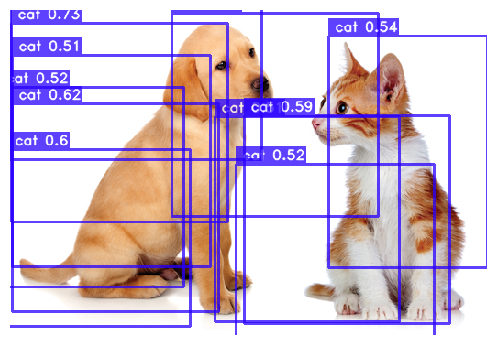

In [23]:
img = cv2.imread("/content/catanddog.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
outputs = model.predict(img)
outputs.show()